In [1]:
import pandas as pd
import numpy as np
import csv
import pickle
from collections import Counter
import matplotlib.pyplot as plt
import powerlaw,math
import os
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import random
import seaborn as sns

In [2]:
files_csv = ['chemistry_0119.csv', 'physics_0119.csv', 'neuro_0119.csv']

[(922, 1196, 58, 41), (922, 1196, 110, 91), (922, 1196, 242, 269), (922, 1196, 483, 566)]
[(941, 1296, 46, 35), (941, 1296, 109, 89), (941, 1296, 251, 256), (941, 1296, 505, 556)]
[(1096, 1656, 64, 65), (1096, 1656, 134, 127), (1096, 1656, 327, 349), (1096, 1656, 572, 747)]
[(372, 640, 33, 32), (372, 640, 60, 57), (372, 640, 113, 137), (372, 640, 214, 291)]
[(284, 538, 18, 18), (284, 538, 42, 34), (284, 538, 83, 105), (284, 538, 164, 234)]
[(391, 679, 20, 24), (391, 679, 40, 53), (391, 679, 102, 144), (391, 679, 211, 304)]
[(229, 348, 14, 14), (229, 348, 23, 30), (229, 348, 60, 76), (229, 348, 101, 171)]
[(397, 553, 26, 27), (397, 553, 45, 51), (397, 553, 109, 115), (397, 553, 209, 263)]
[(504, 816, 29, 47), (504, 816, 51, 85), (504, 816, 139, 206), (504, 816, 267, 400)]


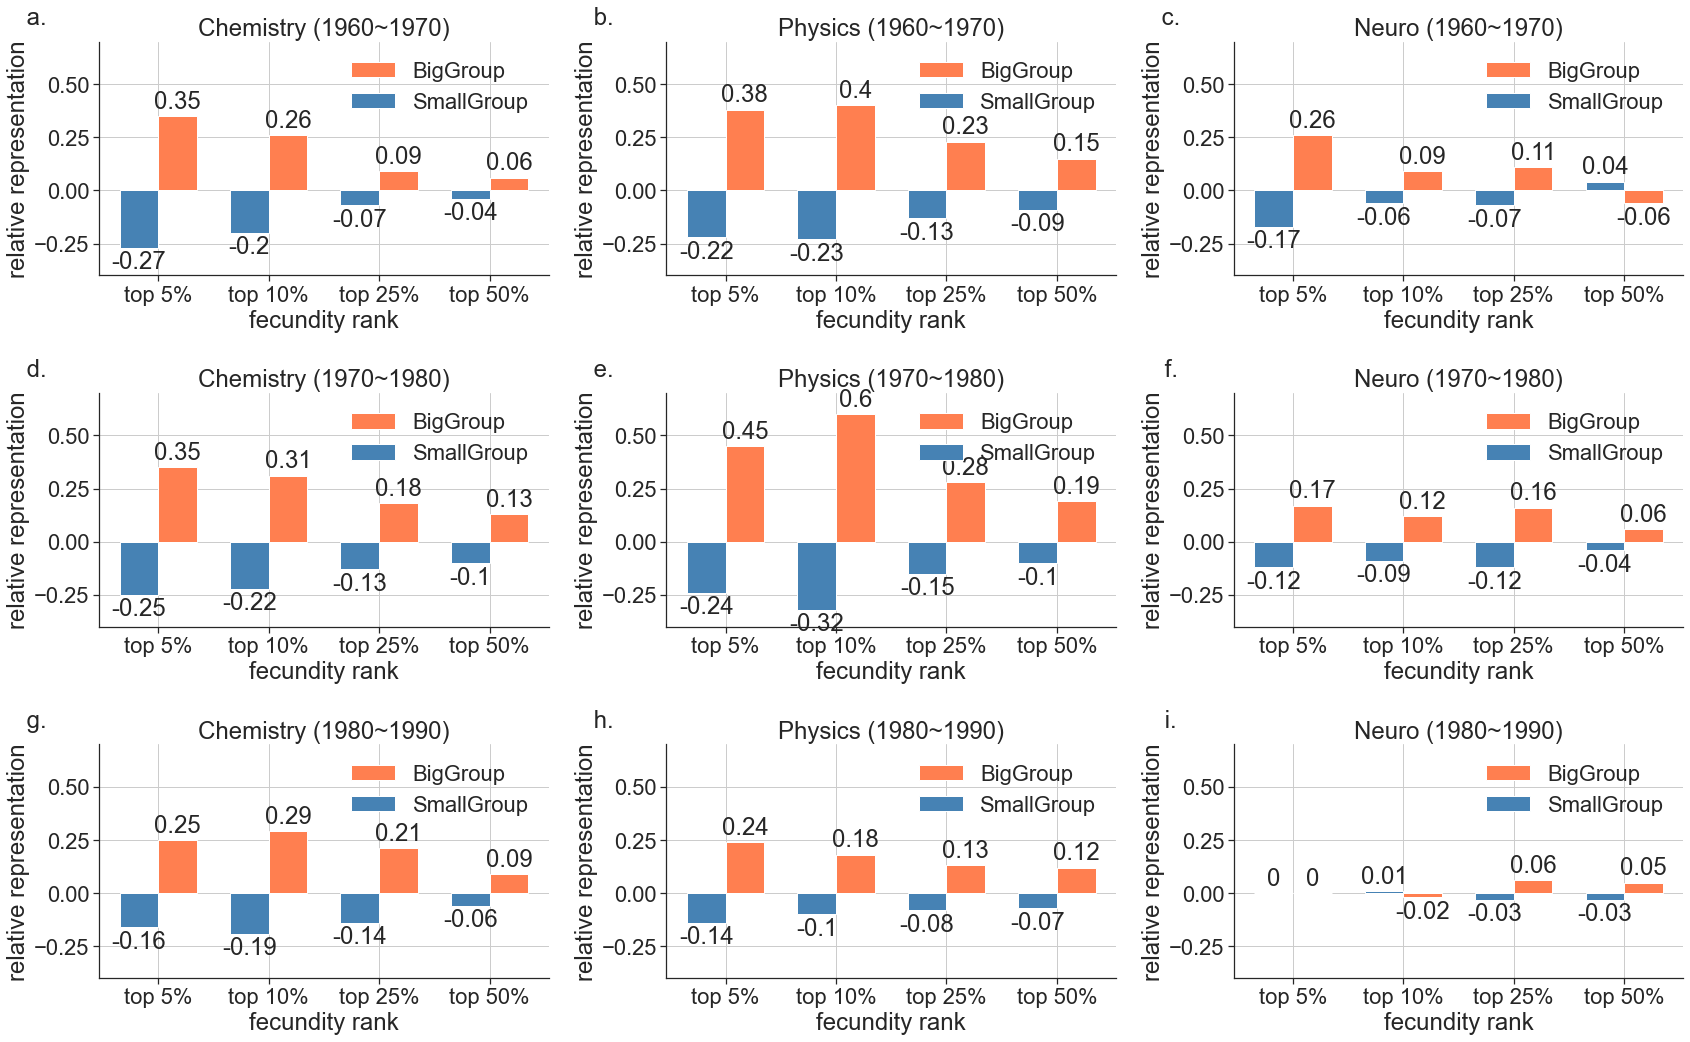

In [14]:
sns.set(style='ticks', font_scale=2, font='Arial')
l_index = [' a. ',' b. ',' c. ',' d. ',' e. ',' f. ',' g. ',' h. ',' i. ',' j. ',' k. ',' l. ']
Titles = ['Chemistry','Physics','Neuro','Math']
fig = plt.figure(figsize=(24,15),tight_layout=1)
# start_end = [[1960,1970],[1970,1980],[1980,1990],[1990,1995]]
start_end = [[1960,1970],[1970,1980],[1980,1990]]
l_index = [' a. ',' b. ',' c. ',' d. ',' e. ',' f. ',' g. ',' h. ',' i. ',' j. ',' k. ',' l. ']
Titles = ['Chemistry','Physics','Neuro']
for ii in range(3):
# #大小团队分组标准 (big and small group)

    k = files_csv[ii]
    neuro = pd.read_csv(k)
    interval = 1
    for se in start_end:
        start = se[0]
        end = se[1]
        y_success = 'YearlyCitationOfMentee'
        neuro_19602000 = neuro[(neuro['StopYear']>=start)&(neuro['StopYear']<=end)]

        #根据当时时代的基数重新划分bigorsmall (tempotally regroup small and big groups)
        mentees_groupsize = np.array(neuro_19602000[['MenteeID','NumOfMenteesOfTheMentor10']])
        mm = sorted(mentees_groupsize,key = lambda x:x[1],reverse=1)
        pt = 0.25
        pt1 = 0.3
#         print(round(len(mm)*pt),round(len(mm)*pt1))
        
        big = mm[:round(len(mm)*pt)]
        bigGroup = list(set([tt[0] for tt in big]))
        small = mm[-round(len(mm)*pt1):]
        smallGroup = list(set([tt[0] for tt in small]))
#         print(len(big),len(small))
        
        n_bigGroup = neuro_19602000['NumOfMenteesOfTheMenteeIn20'][neuro_19602000.MenteeID.isin(bigGroup)]
        n_smallGroup = neuro_19602000['NumOfMenteesOfTheMenteeIn20'][neuro_19602000.MenteeID.isin(smallGroup)]

#         print('大组中的总学生数：',len(n_bigGroup))
#         print('小组中的总学生数：',len(n_smallGroup))

        n_bigGroup1 = neuro_19602000[y_success][(neuro_19602000.MenteeID.isin(bigGroup))
                                                                       &(neuro_19602000.Survival0==1)]
        n_smallGroup1 = neuro_19602000[y_success][(neuro_19602000.MenteeID.isin(smallGroup))
                                                                   &(neuro_19602000.Survival0==1)]

        #计算整体的精英分层 y_success (elite rank)
        All_mentee_level = np.array(neuro_19602000[y_success][neuro_19602000['Survival0']==1])
        TP = sorted(All_mentee_level,reverse=1)
        perctil = [0.05,0.1,0.25,0.5]
        data0 = n_bigGroup1
        data1 = n_smallGroup1
        BR = len(data0)/(len(data0)+len(data1))
        SR = len(data1)/(len(data0)+len(data1))
        RP = [] #representation
        NM = [] #number
        l = len(TP)
        for pt in perctil:
            temp = TP[:round(l*pt)][-1]   #精英分层的阈值 (the threshold of elites)
            b_in = [d0 for d0 in data0 if d0>=temp]   #大团队中学生在经营层的数量 (elites from big groups)
            s_in = [d0 for d0 in data1 if d0>=temp]   #小团队团队中学生在经营层的数量 (elite from small groups)
            try:
                big_rp = len(b_in)/(len(b_in)+len(s_in))
            except:
                big_rp = 0
            try:
                small_rp = len(s_in)/(len(b_in)+len(s_in))
            except:
                small_rp = 0

            try:
                big_rp_relative = big_rp/BR - 1
            except:
                big_rp_relative = -1
            try:
                small_rp_relative = small_rp/SR - 1
            except:
                small_rp_relative = -1

            RP.append((big_rp,small_rp,big_rp_relative,small_rp_relative))
            NM.append((len(data0),len(data1),len(b_in),len(s_in)))
        print(NM)
        y_b = [round(j[2],2) for j in RP]
        y_s = [round(j[3],2) for j in RP]
        X_ticks = ['top 5%','top 10%','top 25%','top 50%']
        width = 0.35
        x = np.array(range(4))
        
        ax = fig.add_subplot(3,3,ii+interval)
        ax.text(-0.14, 1.1,l_index[ii+interval-1],ha='center', va='center', transform=ax.transAxes)
        interval+=3
        rects1 = ax.bar(x+width/2,y_b,width,label='BigGroup',color='coral')
#         print(str(start)+' y_b:',y_b)
        rects2 = ax.bar(x-width/2,y_s,width,label='SmallGroup',color='steelblue')
#         print(str(start)+' y_s:',y_s)
        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)
        ax.set_ylabel('relative representation')
        ax.set_xlabel('fecundity rank')
        c = ax.set_xticks(ticks=x,labels=X_ticks)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.set_ylim([-0.4,0.7])
        legend = ax.legend(loc='upper right')
        frame = legend.get_frame() 
        frame.set_alpha(1) 
        frame.set_facecolor('none') 
        legend.get_frame().set_linewidth(0.0)
        ax.grid(True,which='both',ls="-")
        ax.set_title(Titles[ii]+' ('+str(start)+'~'+str(end)+')')
        
# ax.set_title('Survival mentee')
fig.savefig('relative_representation_evolution1.pdf')

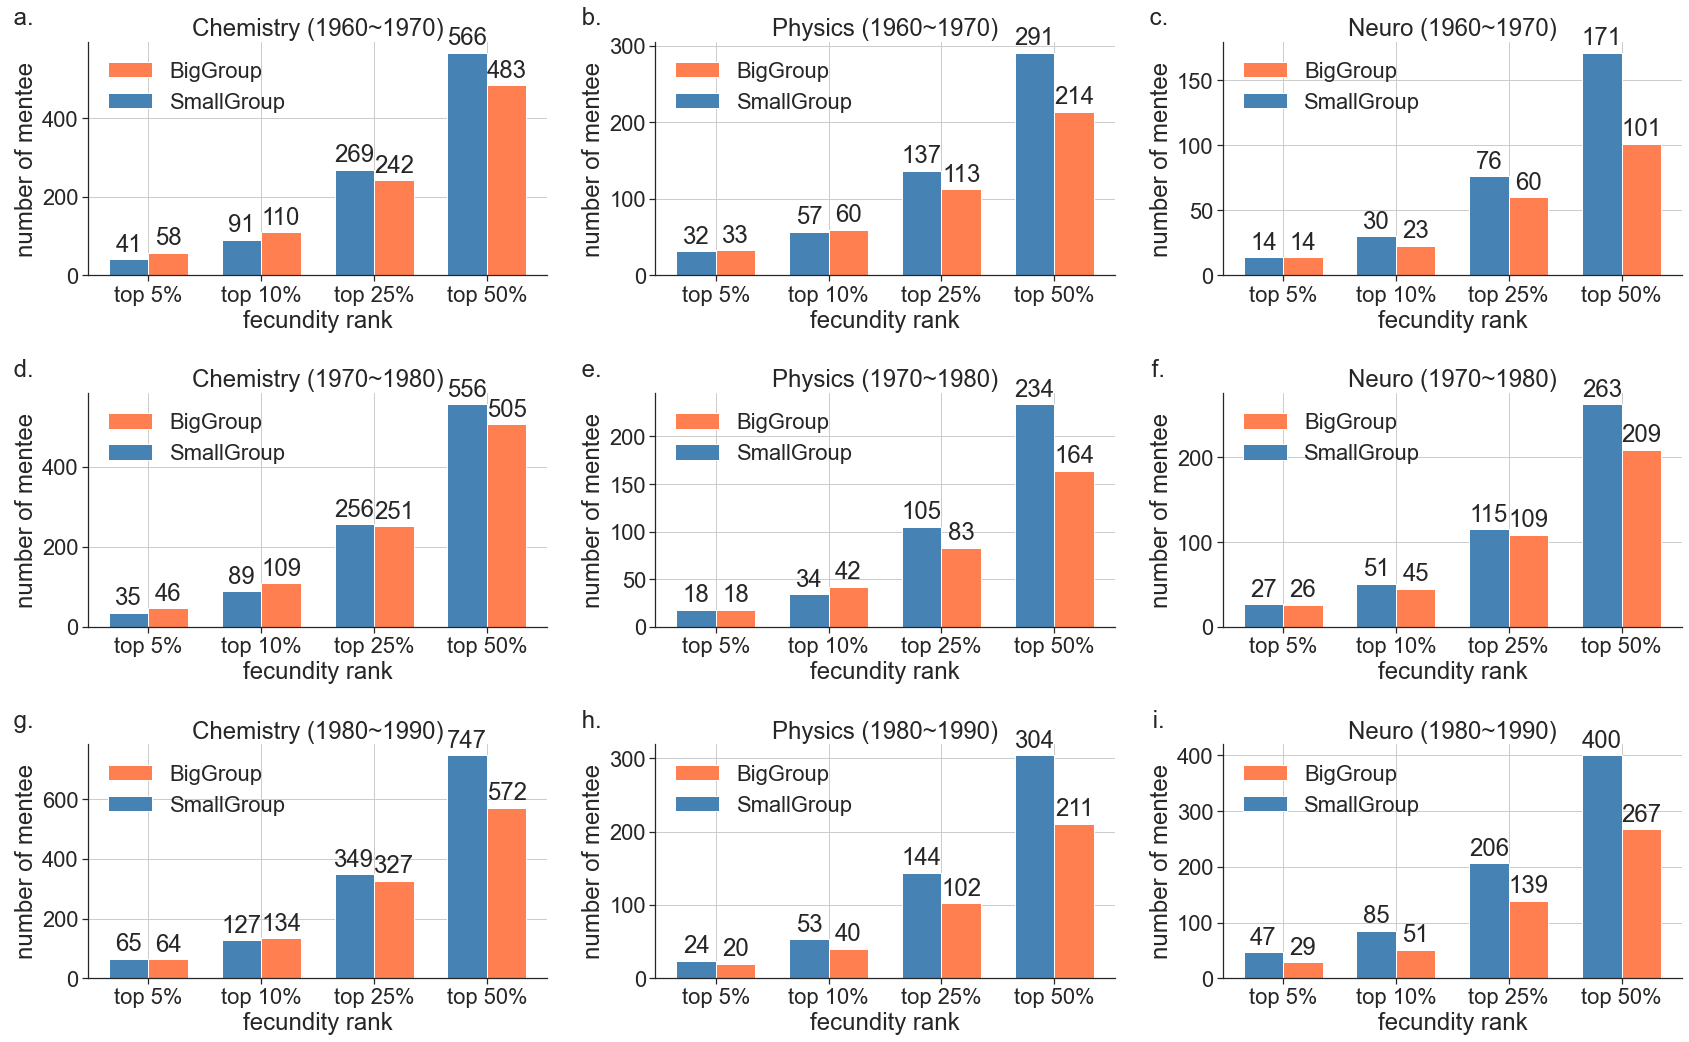

In [13]:
sns.set(style='ticks', font_scale=2, font='Arial')
l_index = [' a. ',' b. ',' c. ',' d. ',' e. ',' f. ',' g. ',' h. ',' i. ',' j. ',' k. ',' l. ']
Titles = ['Chemistry','Physics','Neuro','Math']
fig = plt.figure(figsize=(24,15),tight_layout=1)
# start_end = [[1960,1970],[1970,1980],[1980,1990],[1990,1995]]
start_end = [[1960,1970],[1970,1980],[1980,1990]]
l_index = [' a. ',' b. ',' c. ',' d. ',' e. ',' f. ',' g. ',' h. ',' i. ',' j. ',' k. ',' l. ']
Titles = ['Chemistry','Physics','Neuro']
for ii in range(3):
# #大小团队分组标准 (big and small groups)

    k = files_csv[ii]
    neuro = pd.read_csv(k)
    interval = 1
    for se in start_end:
        start = se[0]
        end = se[1]
        y_success = 'YearlyCitationOfMentee'
        neuro_19602000 = neuro[(neuro['StopYear']>=start)&(neuro['StopYear']<=end)]

        #根据当时时代的基数重新划分bigorsmall (temporally regroup small and big groups)
        mentees_groupsize = np.array(neuro_19602000[['MenteeID','NumOfMenteesOfTheMentor10']])
        mm = sorted(mentees_groupsize,key = lambda x:x[1],reverse=1)
        pt = 0.25
        pt1 = 0.3
#         print(round(len(mm)*pt),round(len(mm)*pt1))
        
        big = mm[:round(len(mm)*pt)]
        bigGroup = list(set([tt[0] for tt in big]))
        small = mm[-round(len(mm)*pt1):]
        smallGroup = list(set([tt[0] for tt in small]))
#         print(len(big),len(small))
        
        n_bigGroup = neuro_19602000['NumOfMenteesOfTheMenteeIn20'][neuro_19602000.MenteeID.isin(bigGroup)]
        n_smallGroup = neuro_19602000['NumOfMenteesOfTheMenteeIn20'][neuro_19602000.MenteeID.isin(smallGroup)]

#         print('大组中的总学生数：',len(n_bigGroup))
#         print('小组中的总学生数：',len(n_smallGroup))

        n_bigGroup1 = neuro_19602000[y_success][(neuro_19602000.MenteeID.isin(bigGroup))
                                                                       &(neuro_19602000.Survival0==1)]
        n_smallGroup1 = neuro_19602000[y_success][(neuro_19602000.MenteeID.isin(smallGroup))
                                                                   &(neuro_19602000.Survival0==1)]

        #计算整体的精英分层 y_success (elite layer)
        All_mentee_level = np.array(neuro_19602000[y_success][neuro_19602000['Survival0']==1])
        TP = sorted(All_mentee_level,reverse=1)
        perctil = [0.05,0.1,0.25,0.5]
        data0 = n_bigGroup1
        data1 = n_smallGroup1
        BR = len(data0)/(len(data0)+len(data1))
        SR = len(data1)/(len(data0)+len(data1))
        RP = [] #representation
        NM = [] #number
        l = len(TP)
        for pt in perctil:
            temp = TP[:round(l*pt)][-1]   #精英分层的阈值 (the threshold of elites)
            b_in = [d0 for d0 in data0 if d0>=temp]   #大团队中学生在经营层的数量 (elites from big groups)
            s_in = [d0 for d0 in data1 if d0>=temp]   #小团队团队中学生在经营层的数量(elites from small groups)
            try:
                big_rp = len(b_in)/(len(b_in)+len(s_in))
            except:
                big_rp = 0
            try:
                small_rp = len(s_in)/(len(b_in)+len(s_in))
            except:
                small_rp = 0

            try:
                big_rp_relative = big_rp/BR - 1
            except:
                big_rp_relative = -1
            try:
                small_rp_relative = small_rp/SR - 1
            except:
                small_rp_relative = -1

            RP.append((big_rp,small_rp,big_rp_relative,small_rp_relative))
            NM.append((len(data0),len(data1),len(b_in),len(s_in)))
#         print(NM)
        y_b = [j[2] for j in NM]
        y_s = [j[3] for j in NM]
        X_ticks = ['top 5%','top 10%','top 25%','top 50%']
        width = 0.35
        x = np.array(range(4))
        
        ax = fig.add_subplot(3,3,ii+interval)
        ax.text(-0.14, 1.1,l_index[ii+interval-1],ha='center', va='center', transform=ax.transAxes)
        interval+=3
        rects1 = ax.bar(x+width/2,y_b,width,label='BigGroup',color='coral')
#         print(str(start)+' y_b:',y_b)
        rects2 = ax.bar(x-width/2,y_s,width,label='SmallGroup',color='steelblue')
#         print(str(start)+' y_s:',y_s)
        ax.bar_label(rects1, padding=3)
        ax.bar_label(rects2, padding=3)
        ax.set_ylabel('number of mentee')
        ax.set_xlabel('fecundity rank')
        c = ax.set_xticks(ticks=x,labels=X_ticks)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
#         ax.set_ylim([-0.4,0.7])
        legend = ax.legend(loc='upper left')
        frame = legend.get_frame() 
        frame.set_alpha(1) 
        frame.set_facecolor('none') 
        legend.get_frame().set_linewidth(0.0)
        ax.grid(True,which='both',ls="-")
        ax.set_title(Titles[ii]+' ('+str(start)+'~'+str(end)+')')
# ax.set_title('Survival mentee')
fig.savefig('representation_number_evolution1.pdf')